In [256]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 
from statsmodels.formula.api import ols


In [ ]:
data=pd.read_csv('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/data/processed/crypto_labeled_data.csv')


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_volume,...,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label,label_name
0,2023-09-12,25162.53,26567.00,25131.48,25840.10,56434.38537,2023-09-12 23:59:59.999,1.464393e+09,1047056,27720.51830,...,-512.111919,26068.5745,27576.7890,27630.36120,27129.522592,25007.626408,32.748983,0.014779,1,HOLD
1,2023-09-13,25840.10,26405.22,25764.17,26222.00,31610.82753,2023-09-13 23:59:59.999,8.254379e+08,714880,15287.00038,...,-448.682032,26070.6720,27516.6508,27645.68585,27132.658711,25008.685289,49.171602,0.011469,1,HOLD
2,2023-09-14,26222.00,26860.49,26126.77,26522.73,38333.17250,2023-09-14 23:59:59.999,1.015267e+09,799278,19440.45467,...,-369.883209,26093.8080,27460.0662,27660.52525,27173.865049,25013.750951,82.762862,0.002913,1,HOLD
3,2023-09-15,26522.73,26888.00,26224.00,26600.00,26227.29369,2023-09-15 23:59:59.999,6.952033e+08,654094,12600.39115,...,-297.767058,26122.9395,27407.6106,27676.06480,27224.395884,25021.483116,85.505788,-0.001516,1,HOLD
4,2023-09-16,26599.99,26777.00,26445.00,26559.67,13960.93351,2023-09-16 23:59:59.999,3.708899e+08,526416,6508.91352,...,-241.089650,26145.8345,27352.5212,27693.15530,27263.495682,25028.173318,83.476095,-0.001211,1,HOLD


In [258]:
# ststistics summary
data.describe()

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
count,800.000000,800.000000,800.000000,800.000000,800.000000,8.000000e+02,8.000000e+02,800.000000,8.000000e+02,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,76608.306400,77982.072250,75202.998837,76691.294988,29768.196722,2.110051e+09,2.896465e+06,14644.371526,1.035624e+09,0.001920,...,55.065883,686.944375,75835.380118,74312.821098,66376.829582,81486.608120,70184.152117,58.801274,0.001890,1.033750
std,27284.313599,27580.225558,26880.913053,27228.548468,19319.547104,1.382443e+09,2.116054e+06,9709.005639,6.901892e+08,0.024775,...,12.571792,1925.557119,27483.493501,27589.979954,25877.613883,28840.704383,26391.812327,27.703305,0.024759,0.570542
min,25162.530000,26397.460000,25131.480000,25840.100000,3282.173520,2.508740e+08,4.217170e+05,1514.419590,1.165812e+08,-0.085387,...,24.133528,-4627.809778,26068.574500,26446.993200,27630.361200,27017.950276,24093.589365,0.451578,-0.085387,0.000000
25%,58834.090000,59920.552500,57473.725000,58949.142500,16681.745440,1.184762e+09,1.400010e+06,8023.788905,5.725748e+08,-0.011175,...,45.659068,-675.290466,59338.628625,59271.308300,43048.640150,64384.109496,53269.721027,36.151701,-0.011175,1.000000
50%,69648.980000,71297.060000,68720.480000,69750.170000,25532.488645,1.772438e+09,2.230046e+06,12521.263254,8.698643e+08,0.000961,...,54.123048,627.617495,68418.847750,66469.712700,63782.784275,73468.998628,63598.383787,62.642197,0.000961,1.000000
75%,102092.127500,104157.495000,99963.077500,102092.125000,37398.201962,2.645482e+09,3.716849e+06,18221.584945,1.301935e+09,0.013099,...,63.308917,1693.824976,100172.328000,98714.319350,90182.606663,107481.358505,93524.863454,83.840192,0.013085,1.000000
max,124658.540000,126199.630000,123084.000000,124658.540000,162065.591860,1.104800e+10,1.201236e+07,77363.263230,5.657171e+09,0.118834,...,87.941054,7019.055192,118285.325500,116632.120400,110444.916800,128011.523790,116672.986260,99.934411,0.118834,2.000000


In [259]:
# check if classes are balanced
data["label"].value_counts()

label
1    539
2    144
0    117
Name: count, dtype: int64

In [260]:
# change datetime to timestamp
data['open_time'] = pd.to_datetime(data['open_time'])
data['close_time'] = pd.to_datetime(data['close_time'])


In [261]:
# check for correlations 
data.corr(numeric_only=True)

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
open,1.000000,0.998813,0.998333,0.997624,-0.322234,0.202562,0.429193,-0.327675,0.185362,-0.094940,...,-0.133264,0.073988,0.989626,0.969705,0.927673,0.989992,0.979268,-0.108826,-0.088811,-0.077577
high,0.998813,1.000000,0.997902,0.998983,-0.302918,0.224037,0.443959,-0.306489,0.209069,-0.058259,...,-0.122871,0.076439,0.989011,0.968796,0.926242,0.990219,0.977740,-0.096793,-0.089959,-0.079403
low,0.998333,0.997902,1.000000,0.998717,-0.349655,0.171088,0.402895,-0.352721,0.156423,-0.058284,...,-0.115924,0.077778,0.987656,0.967741,0.927712,0.987502,0.977887,-0.087985,-0.088710,-0.079105
close,0.997624,0.998983,0.998717,1.000000,-0.322126,0.201640,0.424537,-0.324269,0.188185,-0.029446,...,-0.109906,0.079550,0.987804,0.967489,0.926188,0.988545,0.977055,-0.079427,-0.092774,-0.081950
volume,-0.322234,-0.302918,-0.349655,-0.322126,1.000000,0.810402,0.423169,0.997122,0.816024,0.057172,...,0.167287,0.182044,-0.334178,-0.360024,-0.400041,-0.307246,-0.360247,0.039454,0.047817,0.054636
quote_asset_volume,0.202562,0.224037,0.171088,0.201640,0.810402,1.000000,0.777652,0.804456,0.996467,0.002471,...,0.075104,0.237186,0.183642,0.145526,0.082240,0.217653,0.144627,-0.019896,-0.004326,0.010267
num_trades,0.429193,0.443959,0.402895,0.424537,0.423169,0.777652,1.000000,0.411544,0.762668,-0.061894,...,-0.072994,0.100608,0.426308,0.403092,0.395188,0.455384,0.390245,-0.128572,-0.002100,0.011266
taker_base_volume,-0.327675,-0.306489,-0.352721,-0.324269,0.997122,0.804456,0.411544,1.000000,0.816067,0.106812,...,0.194112,0.193469,-0.341011,-0.367718,-0.407218,-0.313736,-0.367386,0.068878,0.045509,0.051787
taker_quote_volume,0.185362,0.209069,0.156423,0.188185,0.816024,0.996467,0.762668,0.816067,1.000000,0.054555,...,0.107298,0.251266,0.164798,0.125658,0.063572,0.199383,0.125346,0.013684,-0.004662,0.009304
1_day_return,-0.094940,-0.058259,-0.058284,-0.029446,0.057172,0.002471,-0.061894,0.106812,0.054555,1.000000,...,0.357726,0.070709,-0.086912,-0.090716,-0.077636,-0.081883,-0.091533,0.435237,-0.061686,-0.062496


In [262]:
# drop columns that may cause data leakage
data.drop(columns=['future_return','open_time', 'close_time', 'quote_asset_volume'], inplace=True)


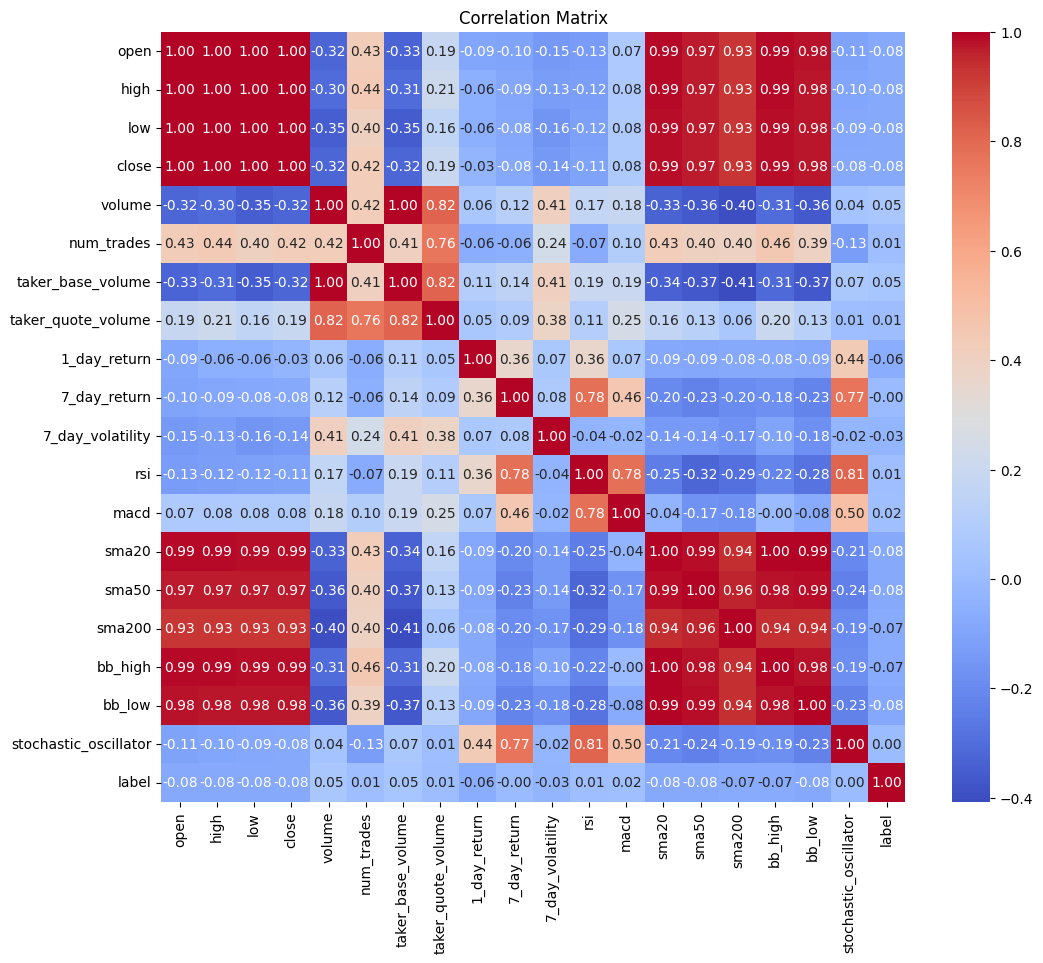

In [263]:
# correlation of numeric columns only
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [264]:
# check for multicollinearity using VIF
X = data.select_dtypes(include=['float64', 'int64'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


                  feature           VIF
0                    open  3.451223e+04
1                    high  2.155434e+04
2                     low  1.462284e+04
3                   close  3.290279e+04
4                  volume  1.231114e+03
5              num_trades  1.367672e+01
6       taker_base_volume  1.286331e+03
7      taker_quote_volume  8.855710e+01
8            1_day_return  1.314545e+01
9            7_day_return  4.690724e+00
10       7_day_volatility  8.329532e+00
11                    rsi  7.230585e+01
12                   macd  4.702758e+01
13                  sma20           inf
14                  sma50  5.892167e+03
15                 sma200  1.299358e+02
16                bb_high           inf
17                 bb_low           inf
18  stochastic_oscillator  2.707076e+01
19                  label  4.333669e+00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [265]:
# Perform ststistical test for significance
formula="close~ open+high+low+volume+num_trades+taker_base_volume+taker_quote_volume+rsi+macd+sma20+sma50+sma200+bb_high+bb_low+stochastic_oscillator+C(label)"
lm=ols(formula=formula,data=data).fit()
table=sm.stats.anova_lm(lm,typ=2)
print(table)


                             sum_sq     df           F        PR(>F)
C(label)               2.152206e+06    2.0    2.707120  6.735329e-02
open                   8.859396e+07    1.0  222.873194  1.557020e-44
high                   1.176109e+08    1.0  295.870201  1.716688e-56
low                    1.306404e+08    1.0  328.648267  1.348109e-61
volume                 4.447654e+06    1.0   11.188830  8.620874e-04
num_trades             4.435219e+06    1.0   11.157549  8.765356e-04
taker_base_volume      2.938246e+06    1.0    7.391657  6.697726e-03
taker_quote_volume     6.089244e+06    1.0   15.318531  9.872446e-05
rsi                    9.388104e+06    1.0   23.617376  1.420006e-06
macd                   3.873067e+07    1.0   97.433594  9.718191e-22
sma20                  5.158585e+07    1.0  129.773001  6.323137e-28
sma50                  3.124925e+07    1.0   78.612804  5.040913e-18
sma200                 9.160555e+05    1.0    2.304494  1.294040e-01
bb_high                1.798689e+0

In [266]:
# define feature columns and target variables,removing all correlated columns from the heatmap
feature_cols =[ 'close', 'volume','num_trades' ,'1_day_return','7_day_volatility','stochastic_oscillator', 'macd', 'sma20', 'bb_high' ]


# create feature matrix X and target y
X = data[feature_cols]
y = data['label']

In [267]:

# Use: - 70% training - 15% validation - 15% test\
# **No shuffling** because cryptocurrency is time-series.
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f'Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}')



Training set size: (560, 9), Validation set size: (120, 9), Test set size: (120, 9)


In [268]:
# # Select numeric columns only
# numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# scaler = StandardScaler()

# # Fit on train, transform train and test
# X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [269]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [270]:
# balance the classes 
smote = SMOTE()   # safe for time series because it does NOT shuffle
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [271]:
print(y_train_resampled.value_counts())


label
1    359
0    359
2    359
Name: count, dtype: int64


In [272]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
pred_rf = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        19
           1       0.68      0.56      0.62        89
           2       0.00      0.00      0.00        12

    accuracy                           0.47       120
   macro avg       0.28      0.29      0.28       120
weighted avg       0.53      0.47      0.49       120



In [273]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_resampled, y_train_resampled)
pred_lgbm = lgbm.predict(X_test)

print("LightGBM:")
print(classification_report(y_test, pred_lgbm))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1077, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM:
              precision    recall  f1-score   support

           0       0.19      0.37      0.25        19
           1       0.73      0.65      0.69        89
           2       0.25      0.08      0.12        12

    accuracy                           0.55       120
   macro avg       0.39      0.37      0.36       120
weighted avg       0.60      0.55      0.56       120



In [274]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_resampled, y_train_resampled)
pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.14      0.26      0.18        19
           1       0.71      0.63      0.67        89
           2       0.00      0.00      0.00        12

    accuracy                           0.51       120
   macro avg       0.28      0.30      0.28       120
weighted avg       0.55      0.51      0.52       120



In [275]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=False)
cat.fit(X_train_resampled, y_train_resampled)
pred_cat = cat.predict(X_test)

print("CatBoost:")
print(classification_report(y_test, pred_cat))


CatBoost:
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        19
           1       0.72      0.60      0.65        89
           2       0.12      0.08      0.10        12

    accuracy                           0.50       120
   macro avg       0.33      0.33      0.32       120
weighted avg       0.57      0.50      0.53       120



In [276]:

# reshape input data for LSTM
X_train_lstm = X_train_resampled.values.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1,   X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1,   X_test.shape[1]))
# build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])
# evaluate on test set
y_test_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3593 - loss: 1.0993 - val_accuracy: 0.2500 - val_loss: 1.0989
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3370 - loss: 1.1029 - val_accuracy: 0.2583 - val_loss: 1.1020
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3268 - loss: 1.1011 - val_accuracy: 0.1333 - val_loss: 1.1159
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3380 - loss: 1.0989 - val_accuracy: 0.1583 - val_loss: 1.0993
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3630 - loss: 1.0971 - val_accuracy: 0.1583 - val_loss: 1.0933
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3565 - loss: 1.0987 - val_accuracy: 0.1500 - val_loss: 1.1032
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3510 - loss: 1.0987 - val_accuracy: 0.1583 - val_loss: 1.0982
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3491 - loss: 1.0985 - val_accuracy: 0.1583 - va

In [277]:
#since i now each model's performance, i can choose the best one for deployment and save it in the models section or file
import joblib
joblib.dump(rf,'/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/random_forest_model.pkl')
joblib.dump(lgbm, '/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/lightgbm_model.pkl')
joblib.dump(xgb, '/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/xgboost_model.pkl')
joblib.dump(cat, '/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/catboost_model.pkl')
lstm_model.save('/Users/josephmutui/Desktop/LuxDev/Python-class/crypto-classifier/models/lstm_model.h5')